# Calculating Accessibility at Scale

**Author:** Alexander Michels

This notebook uses travel-time catchments calculated using the E2SFCA method to calculate spatial accessibility using the [Enhanced Two-Step Floating Catchment Area (E2SFCA)](https://doi.org/10.1016/j.healthplace.2009.06.002) method.

In [1]:
from collections import Counter
import contextily as cx
import folium
import geopandas as gpd
import itertools
import json
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import multiprocessing as mp
import os
import pandas as pd
import sys
from shapely.geometry import Point, LineString, Polygon
import time
import tqdm

# Table of Contents

* [E2SFCA Implementation](#e2sfca)
* [Illinois](#il)
* [Midwest](#mw)
* [Contiguous U.S.](#cont)

<hr id="e2sfca">

# E2SFCA Implementation

The Enhanced Two-Step Floating Catchment Area method uses two steps to calculate accessibility: (1) calculating resource to population ratios for each resource location (hospital) and (2) aggregating those ratios across space.


First, we have a very simple helper function which takes a geodataframe, makes a deep copy of it, and replaces the geometry with the centroids. This is because E2SFCA uses centroids of population data to determine inclusion/exclusion from a catchment.

In [2]:
def calculate_centroid(geodata):
    """Replaces the geometry in `geodata` with the centroid

    Args:
      geodata: GeoDataFrame

    Returns:
      GeoDataFrame (`geodata`) with geometry replaced by centroids
    """
    centroids = geodata.copy(deep=True)
    centroids["geometry"] = centroids.centroid
    return(centroids)

Next we have a simple function for performing the first step: calcualting resource to population ratios for each hospital. For each travel-time distance (E2SFCA uses 10, 20, and 30 minutes in their initial paper and we do the same here), we calculate which population data centroids fall within each catchment, calculate a weighted sum of the population within each catchment, and divide the resources at each hospital by the weighted sum.

In [3]:
def catchment_ratios_centroid(catchments, write_to, catchment_id, pop_data, pop_field, resource, distances, weights):
    """Calculates the resource to population ratios for each hospital using centroids.
    https://doi.org/10.1016/j.healthplace.2009.06.002

    Args:
      catchments: list of GeoDataFrames representing the catchments
      write_to: the field to write the ratio to in the catchments GeoDataFrame
      catchment_id: ID field for catchment GeoDataFrames
      pop_data: population GeoDataFrame
      pop_field: `pop_data` population field
      resource: resource field in catchments GeoDataFrames
      distances: list of distances
      weights: list of numerical weights where weights[i] applies to distances[i]

    Return:
      List of GeoDataFrames (catchments) with resource to population ratios for each catchment.
    """
    pop_data = calculate_centroid(pop_data)
    for dist_i, distance in tqdm.tqdm(enumerate(distances), total=len(distances), desc="Calculating Population:", position=0):
        intersect = gpd.overlay(pop_data.copy(deep=True), catchments[dist_i], how='intersection')
        catchments[dist_i] = catchments[dist_i].join(intersect.groupby(catchment_id)[pop_field].sum(), on=catchment_id, rsuffix='_r')
        catchments[dist_i][pop_field] = catchments[dist_i][pop_field].fillna(value=0)
        catchments[dist_i]["weighted_pop"] = catchments[dist_i][pop_field] * weights[dist_i]
        catchments[dist_i]['time'] = distance
    population_per_resource = Counter()
    for dist_i, distance in enumerate(distances):
        for resource_id, pop in zip(catchments[dist_i][catchment_id], catchments[dist_i]["weighted_pop"]):
            population_per_resource[resource_id] += pop
    population_pd = pd.DataFrame(population_per_resource.items(), columns=[catchment_id, "total_weighted_pop"])
    for dist_i, distance in enumerate(distances):
        catchments[dist_i] = catchments[dist_i].merge(population_pd.copy(), how='left', on=catchment_id)
        catchments[dist_i][write_to] = catchments[dist_i][resource] / catchments[dist_i]["total_weighted_pop"]
    return catchments

With that calculated, we aggregate the resource-to-population ratios back to the population geographies:

In [4]:
def aggregate_ratios_centroid(agg_gdf, agg_id, catchments, service_type, weights):
    """Aggregates the accessibility measure to the `agg_gdf` which stands
    for aggregation GeoDataFrame using centroids.

    Args:
      agg_gdf: GeoDataFrame to aggregate values to
      agg_id: ID field for `agg_gdf`
      catchments: list of GeoDataFrames which contain catchments
      service_type: value to aggregate
      weights: list of numerical weights where weights[i] corresponds to catchment[i]

    Returns:
      GeoDataFrame (agg_gdf) with aggregated spatial accessibility measures
    """
    service_values = Counter()
    agg_gdf_for_intersect = calculate_centroid(agg_gdf)
    for catch_i in tqdm.tqdm(range(len(catchments)), desc="Calculating Intersections", position=0):
        intersect = gpd.overlay(agg_gdf_for_intersect, catchments[catch_i], how="intersection")
        intersect = intersect.groupby(agg_id)[service_type].sum().reset_index()
        for aid, val in zip(intersect[agg_id], intersect[service_type]):
            service_values[aid] += float(val * weights[catch_i])
    service_pd = pd.DataFrame(service_values.items(), columns=[agg_id, service_type])
    agg_gdf = agg_gdf.merge(service_pd, how='left', on=agg_id)
    return agg_gdf

This is a "wrapper" function which calls the last two functions and does a bit of data cleaning in between by removing catchments with infinity values.

In [5]:
def e2sfca(catchments, write_to, catchment_id, pop_data, pop_id, pop_field, resource, distances, weights):
    """Calculates Enhanced Two-Step Floating Catchment Area (E2SFCA).
    https://doi.org/10.1016/j.healthplace.2009.06.002

    Args:
      catchments: list of GeoDataFrames representing the catchments
      write_to: the field to write the ratio to in the catchments GeoDataFrame
      catchment_id: ID field for catchment GeoDataFrames
      pop_data: population GeoDataFrame
      pop_id: `pop_data` ID field
      pop_field: `pop_data` population field
      resource: resource field in catchments GeoDataFrames
      distances: list of distances
      weights: list of numerical weights where weights[i] applies to distances[i]

    Return:
      geopandas.GeoDataFrame
    """
    catchments = catchment_ratios_centroid(catchments, write_to, catchment_id, pop_data, pop_field, resource, distances, weights)
    for catch_i in range(len(catchments)):
        # remove infs
        catchments[catch_i] = catchments[catch_i][catchments[catch_i][write_to] != float('inf')]
    return aggregate_ratios_centroid(pop_data, pop_id, catchments, write_to, weights)

Lastly, let's define a function to make pretty maps for us. This will give us a standardized function for generating maps of the results:

In [6]:
def output_map(output_gdf, base_map, resource, alpha=1, cmap='OrRd', colorbar_text=None, figsize=(18, 12),
               integer_ticks=None, save=None, vmax=None, vmin=None) -> None:
    """Plots or saves graph of the output.

    Args:
      output_gdf (GeoDataFrame): GeoDataFrame with geometries you've aggregated spatial accessibility to.
      base_map (GeoDataFrame): county/state/country shapes
      resource (str): field in `output_gdf` to plot with
      alpha (float): matplotlib alpha
      cmap (str): colormap
      colorbar_text (str): text label for colorbar
      figsize (tuple of numbers): matplotlib figsize
      save (str/Path): if None doesn't save, else saves to `save`
      vmax (float): maximum value on colorbar
      vmin (Numer): minimum value on colorbar

    Returns:
      None
    """
    font_size = 24
    edgecolor = "black"
    null_color = "grey"  # color for no access
    if cmap == "viridis":
        edgecolor = "white"
    # plt.rcParams.update({'font.size': font_size})
    # colorbar == plot height due to: https://github.com/geopandas/geopandas/pull/894
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # ternary operator: https://book.pythontips.com/en/latest/ternary_operators.html
    vmax = max(output_gdf[resource]) if (vmax is None) else vmax
    vmin = min(output_gdf[resource]) if (vmin is None) else vmin
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.2)
    cax.tick_params(labelsize=font_size)
    ax = output_gdf.plot(column=resource, ax=ax, cmap=cmap, alpha=alpha, zorder=1,
                         antialiased=False, edgecolor="none", missing_kwds=dict(color=null_color),
                         vmin=vmin, vmax=vmax)
    FIG_PAD = 0.02
    XPAD = abs(output_gdf.total_bounds[0] - output_gdf.total_bounds[2]) * FIG_PAD
    YPAD = abs(output_gdf.total_bounds[1] - output_gdf.total_bounds[3]) * FIG_PAD
    xlim = ([output_gdf.total_bounds[0] - XPAD, output_gdf.total_bounds[2] + XPAD])
    ylim = ([output_gdf.total_bounds[1] - YPAD, output_gdf.total_bounds[3] + YPAD])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    colorbarsm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    colorbarsm._A = []
    if integer_ticks is not None:
        tick_spacing = round(int(vmax - vmin) / (integer_ticks - 1))
        ticks = list(range(math.floor(vmin), math.ceil(vmax) + 1, tick_spacing))
        colorbar = fig.colorbar(colorbarsm, cax=cax, ticks=ticks)
        ticklabels = [str(tick) for tick in ticks]
        if ticks[0] > min(output_gdf[resource]):
            ticklabels[0] = r"$\leq${}".format(ticklabels[0])
        if ticks[-1] < max(output_gdf[resource]):
            ticklabels[-1] = r"$\geq${}".format(ticklabels[-1])
        colorbar.ax.set_yticklabels(ticklabels)
    else:
        colorbar = fig.colorbar(colorbarsm, cax=cax)
    if colorbar_text is not None:
        colorbar.set_label(colorbar_text, fontsize=font_size, labelpad=12, rotation=270)
    base_map.plot(ax=ax, facecolor="none", edgecolor=edgecolor, lw=0.2)
    cx.add_basemap(ax, crs=base_map.crs.to_string())
    ax.set_axis_off()
    ax.margins(0)
    plt.tight_layout()
    if save is not None:
        plt.savefig(save, dpi=200)


<hr id="il">

# Illinois

In [7]:
PARAMS = {
    "access": {
        "weights": [1.0, 0.68, 0.22],
        "projection": "ESRI:102003"
    },
    "compute": {
        "max_memory" : 16,
        "threads" : 8
    },
    "graphml": {
        "geo_unit_key" : "GEOID",
        "geo_unit_shapefile" : "../data/geodata/counties/ILCounties/ILCountyShapefile.shp",
        "dir" : "../data/graphml/ilcounties/graphml",
        "name_format" : "0500000US{}.graphml",
        "memory_csv" : "../data/memory_df/ILCounty-MemoryUsage.csv",
        "memory_column" : "Memory Usage (GB)",
        "memory_key" : "GEOID"
    },
    "output": {
        "figsize": [12, 18]
    },
    "pop" : {
        "file": "../data/pop/illinois/SVI2018_IL_tract.shp",
        "pop_field": "E_TOTPOP",
        "pop_key": "FIPS"
    },
    "region" : {
        "batch_size": 4,
        "buffer": 64374,
        "catchment_file_pattern": "resource_catchments_{}distance.geojson",
        "catchment_how": "convexhull",
        "distances": [600, 1200, 1800],
        "dir": "../data/regions/Illinois",
        "projection" : "ESRI:102003"
    },
    "resource" : {
        "key": "ID",
        "resource": "BEDS",
        "shapefile" : "../data/hospitals/illinois/IllinoisHospitals.shp"
    }
}
PARAMS["access"]["val"] = "ratio-{}".format(PARAMS["resource"]["resource"])

Let's load, project, and plot the population data:

In [8]:
pop_data = gpd.read_file(PARAMS["pop"]["file"])
pop_data = pop_data.to_crs(PARAMS["region"]["projection"])
pop_data[PARAMS["pop"]["pop_key"]] = pop_data[PARAMS["pop"]["pop_key"]].fillna(value=0)
pop_data.head()

ST     STATE ST_ABBR STCNTY COUNTY         FIPS  \
0  17  ILLINOIS      IL  17031   Cook  17031381700   
1  17  ILLINOIS      IL  17031   Cook  17031980000   
2  17  ILLINOIS      IL  17031   Cook  17031980100   
3  17  ILLINOIS      IL  17097   Lake  17097863005   
4  17  ILLINOIS      IL  17097   Lake  17097863006   

                                      LOCATION  AREA_SQMI  E_TOTPOP  M_TOTPOP  \
0     Census Tract 3817, Cook County, Illinois   0.075986         0        11   
1     Census Tract 9800, Cook County, Illinois   7.679554         0        11   
2     Census Tract 9801, Cook County, Illinois   1.151272         0        11   
3  Census Tract 8630.05, Lake County, Illinois   0.393745       440       607   
4  Census Tract 8630.06, Lake County, Illinois   0.080025         0        11   

   ...  F_THEME4  F_TOTAL  E_UNINSUR  M_UNINSUR  EP_UNINSUR  MP_UNINSUR  \
0  ...      -999     -999          0         11      -999.0      -999.0   
1  ...      -999     -999          0         11      -999.0      -999.0   
2  ...      -999     -999          0         11      -999.0      -999.0   
3  ...      -999     -999          0         11      -999.0      -999.0   
4  ...      -999     -999          0         11      -999.0      -999.0   

   E_DAYPOP  Shape_STAr  Shape_STLe  \
0       551    0.000021    0.020359   
1     38202    0.002171    0.222431   
2      6449    0.000323    0.076961   
3       108    0.000111    0.053599   
4      2642    0.000023    0.018743   

                                            geometry  
0  POLYGON ((689645.410 513172.412, 689877.534 51...  
1  POLYGON ((662183.100 533025.072, 662292.722 53...  
2  POLYGON ((678843.600 510378.604, 679647.276 51...  
3  POLYGON ((666628.417 566052.998, 666641.522 56...  
4  POLYGON ((666290.205 566023.937, 666268.776 56...  

[5 rows x 127 columns]

<AxesSubplot:>

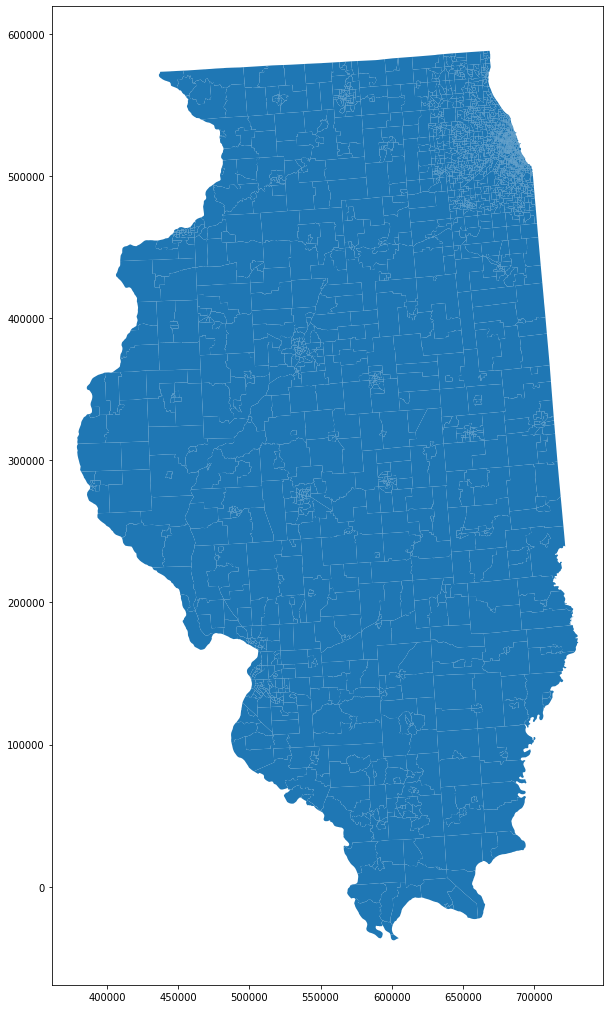

In [9]:
pop_data.plot(figsize=PARAMS["output"]["figsize"])

We can also load the catchments and do a bit of cleaning on those:

* ensure that the amount of hospital beds is positive for each hospital
* ensure that our catchment is a Polygon or Multipolygon (not a line or point)
* project the data

In [10]:
catchments = []
for dist_i, distance in enumerate(PARAMS["region"]["distances"]):
    catchments.append(gpd.read_file(os.path.join(PARAMS["region"]["dir"],PARAMS["region"]["catchment_file_pattern"].format(distance)), driver="GeoJSON"))
    catchments[dist_i] = catchments[dist_i][catchments[dist_i][PARAMS["resource"]["resource"]] > 0]
    catchments[dist_i] = catchments[dist_i].dropna(subset=[PARAMS["resource"]["resource"]])
    catchments[dist_i] = catchments[dist_i][(catchments[dist_i].geom_type == "Polygon") | (catchments[dist_i].geom_type == "MultiPolygon")]
    catchments[dist_i] = catchments[dist_i].to_crs(PARAMS["region"]["projection"])
catchments[0].head()

OBJECTID          ID                                               NAME  \
0      1645  0099962703  SPRINGFIELD HOSPITAL INC - DBA LINCOLN PRAIRIE...   
2      4301  0016261747                           HOPEDALE MEDICAL COMPLEX   
3      4304  0004461455                       MC DONOUGH DISTRICT HOSPITAL   
4      4418  0097962702                 VIBRA HOSPITAL OF SPRINGFIELD, LLC   
5      4537  0015761443                      OSF SAINT LUKE MEDICAL CENTER   

                   ADDRESS         CITY STATE    ZIP           ZIP4  \
0  5230 SOUTH SIXTH STREET  SPRINGFIELD    IL  62703  NOT AVAILABLE   
2       107 TREMONT STREET     HOPEDALE    IL  61747  NOT AVAILABLE   
3    525 EAST GRANT STREET       MACOMB    IL  61455  NOT AVAILABLE   
4     701 N. WALNUT STREET  SPRINGFIELD    IL  62702  NOT AVAILABLE   
5   1051 WEST SOUTH STREET      KEWANEE    IL  61443  NOT AVAILABLE   

        TELEPHONE                TYPE  ...  \
0  (217) 585-1180         PSYCHIATRIC  ...   
2  (309) 449-3321     CRITICAL ACCESS  ...   
3  (309) 833-4101  GENERAL ACUTE CARE  ...   
4  (217) 528-1217      LONG TERM CARE  ...   
5  (309) 853-3361     CRITICAL ACCESS  ...   

                                     WEBSITE       STATE_ID       ALT_NAME  \
0          http://www.lincolnprairiebhc.com/  NOT AVAILABLE  NOT AVAILABLE   
2                  http://www.hopedalemc.com         141330  NOT AVAILABLE   
3                         http://www.mdh.org         140089  NOT AVAILABLE   
4              http://www.vhspringfield.com/  NOT AVAILABLE  NOT AVAILABLE   
5  https://www.osfhealthcare.org/saint-luke/         141325  NOT AVAILABLE   

  ST_FIPS                            OWNER  TTL_STAFF  BEDS         TRAUMA  \
0      17                    NOT AVAILABLE       -999    88  NOT AVAILABLE   
2      17                       NON-PROFIT       -999    25  NOT AVAILABLE   
3      17  GOVERNMENT - DISTRICT/AUTHORITY       -999    95  NOT AVAILABLE   
4      17                    NOT AVAILABLE       -999    50  NOT AVAILABLE   
5      17                       NON-PROFIT       -999    25  NOT AVAILABLE   

  HELIPAD                                           geometry  
0       N  POLYGON ((540242.543 253034.887, 531152.225 26...  
2       N  POLYGON ((553564.042 340318.098, 552205.898 34...  
3       Y  POLYGON ((447805.068 335515.544, 438858.600 34...  
4       N  POLYGON ((536812.386 268395.283, 534100.534 26...  
5       Y  POLYGON ((502098.223 426508.814, 498724.511 42...  

[5 rows x 33 columns]

<AxesSubplot:>

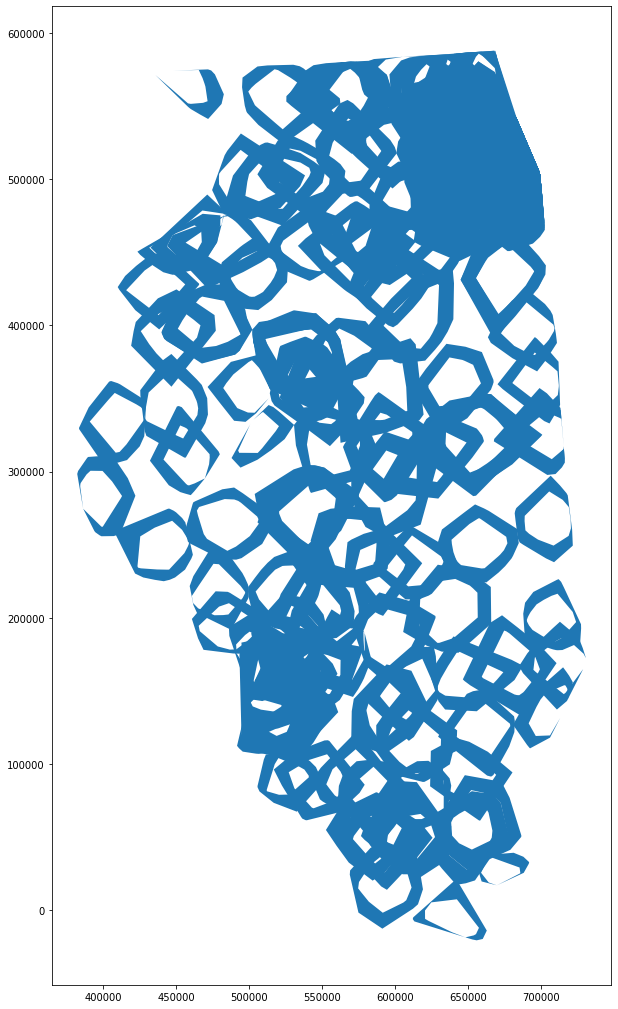

In [11]:
catchments[2].plot(figsize=PARAMS["output"]["figsize"])

In [12]:
result = e2sfca(catchments, PARAMS["access"]["val"], PARAMS["resource"]["key"], 
                pop_data,
                PARAMS["pop"]["pop_key"],
                PARAMS["pop"]["pop_field"],
                PARAMS["resource"]["resource"],
                PARAMS["region"]["distances"],
                PARAMS["access"]["weights"])

Calculating Intersections: 100%|████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.42s/it]


We have our accessibility calculated! Let's check it out:

In [13]:
result.head()

ST     STATE ST_ABBR STCNTY COUNTY         FIPS  \
0  17  ILLINOIS      IL  17031   Cook  17031381700   
1  17  ILLINOIS      IL  17031   Cook  17031980000   
2  17  ILLINOIS      IL  17031   Cook  17031980100   
3  17  ILLINOIS      IL  17097   Lake  17097863005   
4  17  ILLINOIS      IL  17097   Lake  17097863006   

                                      LOCATION  AREA_SQMI  E_TOTPOP  M_TOTPOP  \
0     Census Tract 3817, Cook County, Illinois   0.075986         0        11   
1     Census Tract 9800, Cook County, Illinois   7.679554         0        11   
2     Census Tract 9801, Cook County, Illinois   1.151272         0        11   
3  Census Tract 8630.05, Lake County, Illinois   0.393745       440       607   
4  Census Tract 8630.06, Lake County, Illinois   0.080025         0        11   

   ...  F_TOTAL  E_UNINSUR  M_UNINSUR  EP_UNINSUR  MP_UNINSUR  E_DAYPOP  \
0  ...     -999          0         11      -999.0      -999.0       551   
1  ...     -999          0         11      -999.0      -999.0     38202   
2  ...     -999          0         11      -999.0      -999.0      6449   
3  ...     -999          0         11      -999.0      -999.0       108   
4  ...     -999          0         11      -999.0      -999.0      2642   

   Shape_STAr  Shape_STLe                                           geometry  \
0    0.000021    0.020359  POLYGON ((689645.410 513172.412, 689877.534 51...   
1    0.002171    0.222431  POLYGON ((662183.100 533025.072, 662292.722 53...   
2    0.000323    0.076961  POLYGON ((678843.600 510378.604, 679647.276 51...   
3    0.000111    0.053599  POLYGON ((666628.417 566052.998, 666641.522 56...   
4    0.000023    0.018743  POLYGON ((666290.205 566023.937, 666268.776 56...   

   ratio-BEDS  
0    0.004101  
1    0.004167  
2    0.003924  
3    0.001473  
4    0.001473  

[5 rows x 128 columns]

Let's project our result and adjust the numbers so they are a bit more human friendly by calculating hospital beds per thousand people rather than per person.

In [14]:
result = result.to_crs(PARAMS["access"]["projection"])

In [15]:
result[PARAMS["access"]["val"]] = result[PARAMS["access"]["val"]] * 1000

To create our plot, let's add the outline of the state. To do that, we can load the county data and dissolve by state:

<AxesSubplot:>

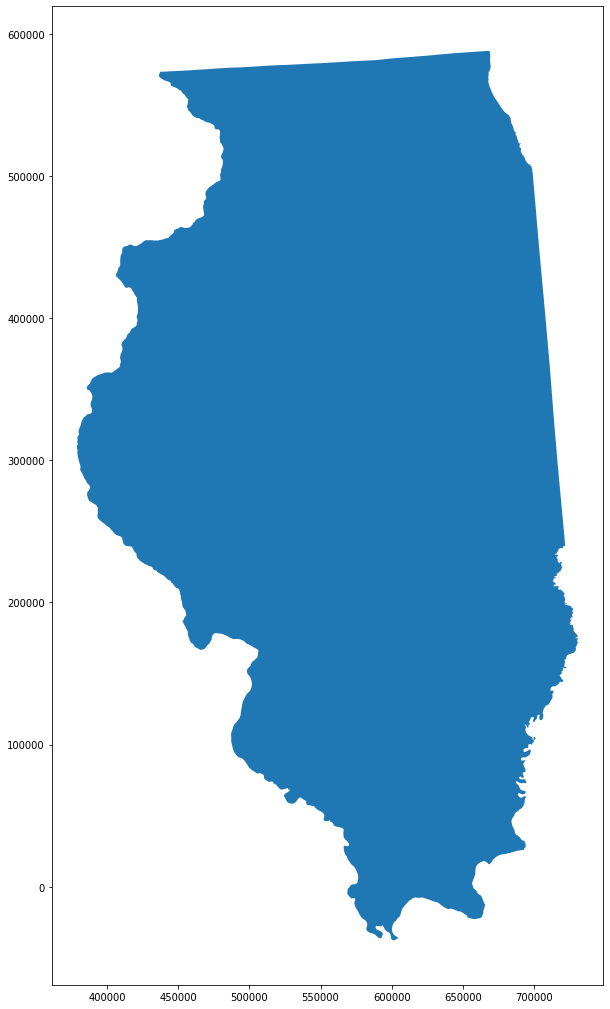

In [16]:
spatial_extent = gpd.read_file(PARAMS["graphml"]["geo_unit_shapefile"])
spatial_extent = spatial_extent.to_crs(PARAMS["access"]["projection"])
spatial_extent = spatial_extent.dissolve(by="STATEFP")
spatial_extent.plot(figsize=PARAMS["output"]["figsize"])

Lastly, let's plot our result:

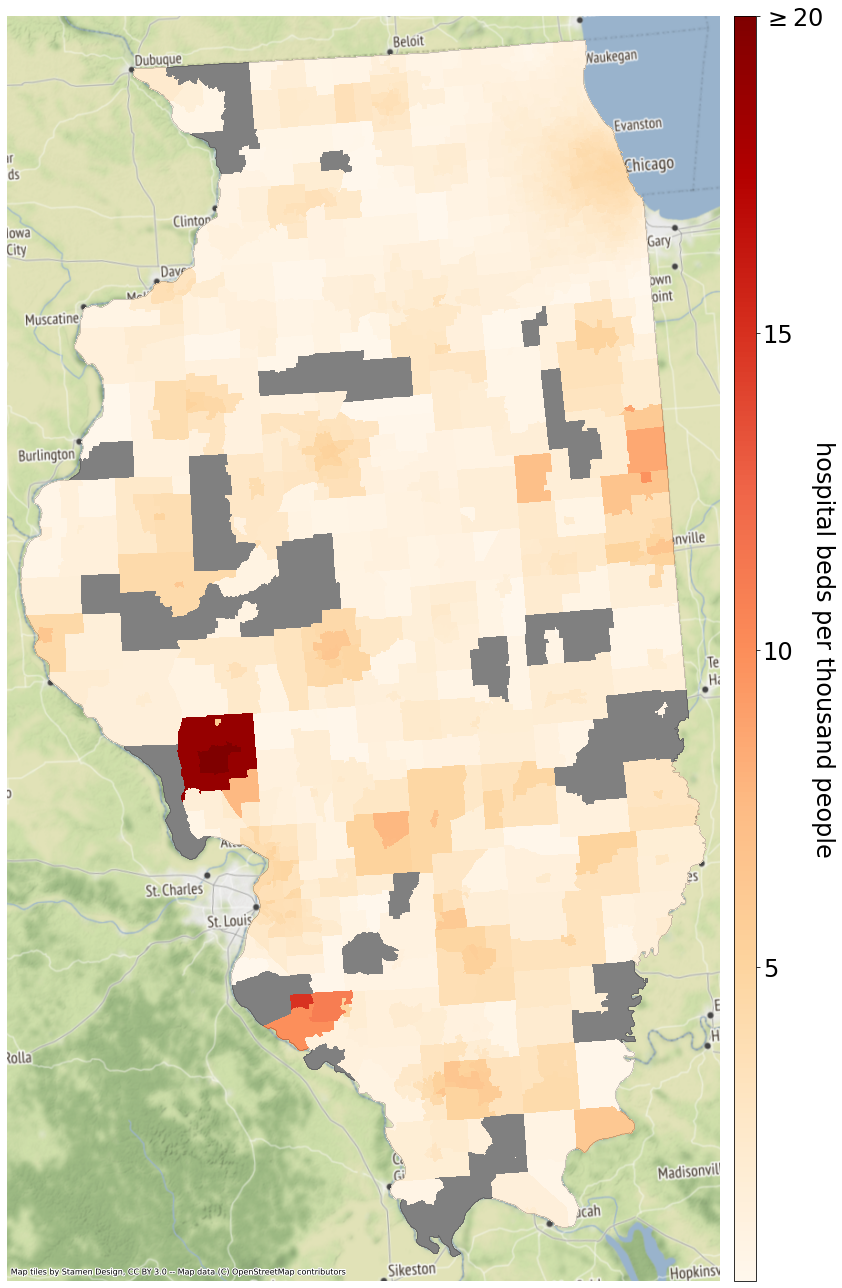

In [17]:
output_map(result, spatial_extent, PARAMS["access"]["val"],
           save=os.path.join(PARAMS["region"]["dir"], "E2SFCA-OrRd.jpg"), cmap='OrRd', 
           figsize=PARAMS["output"]["figsize"], colorbar_text="hospital beds per thousand people",
           vmax=20, integer_ticks=5)

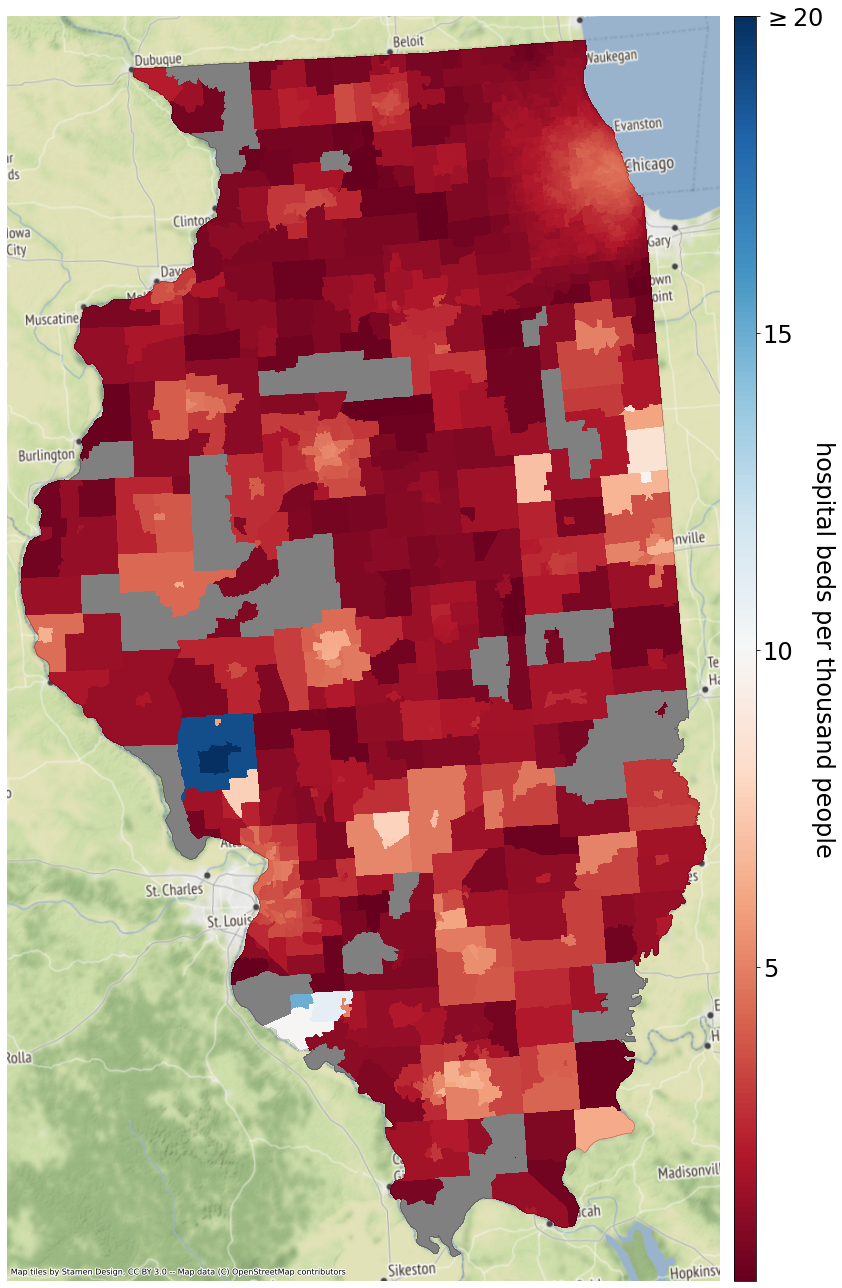

In [18]:
output_map(result, spatial_extent, PARAMS["access"]["val"],
           save=os.path.join(PARAMS["region"]["dir"], "E2SFCA-RdBu.jpg"), cmap='RdBu', 
           figsize=PARAMS["output"]["figsize"], colorbar_text="hospital beds per thousand people",
           vmax=20, integer_ticks=5)

<hr id="mw">

# Midwest

In [19]:
PARAMS = {
    "access": {
        "weights": [1.0, 0.68, 0.22],
        "projection": "ESRI:102003"
    },
    "compute": {
        "max_memory" : 20,
        "threads" : 8
    },
    "graphml": {
        "geo_unit_key" : "GEOID",
        "geo_unit_shapefile" : "../data/geodata/counties/MidwestCounties/MidwestCounties.shp",
        "dir" : "/data/cigi/common/michels9/Midwest-Counties/graphml",
        "name_format" : "0500000US{}.graphml",
        "memory_csv" : "../data/memory_df/MidwestCounty-MemoryUsage.csv",
        "memory_column" : "Memory Usage (GB)",
        "memory_key" : "GEOID"
    },
    "output": {
        "figsize": [16,12],
    },
    "pop" : {
        "file": "../data/pop/midwest/Midwest_SVI_CT.shp",
        "pop_field": "E_TOTPOP",
        "pop_key": "FIPS"
    },
    "region" : {
        "batch_size": 8,
        "buffer": 64374,
        "catchment_file_pattern": "resource_catchments_{}distance.geojson",
        "catchment_how": "convexhull",
        "distances": [600, 1200, 1800],
        "dir": "../data/regions/Midwest",
        "projection" : "ESRI:102003"
    },
    "resource" : {
        "key": "ID",
        "resource": "BEDS",
        "shapefile" : "../data/hospitals/midwest/MidwestHospitals.shp"
    }
}
PARAMS["access"]["val"] = "ratio-{}".format(PARAMS["resource"]["resource"])

In [20]:
pop_data = gpd.read_file(PARAMS["pop"]["file"])
pop_data = pop_data.to_crs(PARAMS["region"]["projection"])
pop_data[PARAMS["pop"]["pop_key"]] = pop_data[PARAMS["pop"]["pop_key"]].fillna(value=0)
pop_data.head()

ST     STATE ST_ABBR STCNTY COUNTY         FIPS  \
0  17  ILLINOIS      IL  17031   Cook  17031381700   
1  17  ILLINOIS      IL  17031   Cook  17031980000   
2  17  ILLINOIS      IL  17031   Cook  17031980100   
3  17  ILLINOIS      IL  17097   Lake  17097863005   
4  17  ILLINOIS      IL  17097   Lake  17097863006   

                                      LOCATION  AREA_SQMI  E_TOTPOP  M_TOTPOP  \
0     Census Tract 3817, Cook County, Illinois   0.075986         0        11   
1     Census Tract 9800, Cook County, Illinois   7.679554         0        11   
2     Census Tract 9801, Cook County, Illinois   1.151272         0        11   
3  Census Tract 8630.05, Lake County, Illinois   0.393745       440       607   
4  Census Tract 8630.06, Lake County, Illinois   0.080025         0        11   

   ...  F_THEME4  F_TOTAL  E_UNINSUR  M_UNINSUR  EP_UNINSUR  MP_UNINSUR  \
0  ...      -999     -999          0         11      -999.0      -999.0   
1  ...      -999     -999          0         11      -999.0      -999.0   
2  ...      -999     -999          0         11      -999.0      -999.0   
3  ...      -999     -999          0         11      -999.0      -999.0   
4  ...      -999     -999          0         11      -999.0      -999.0   

   E_DAYPOP  Shape_STAr  Shape_STLe  \
0       551    0.000021    0.020359   
1     38202    0.002171    0.222431   
2      6449    0.000323    0.076961   
3       108    0.000111    0.053599   
4      2642    0.000023    0.018743   

                                            geometry  
0  POLYGON ((689645.410 513172.412, 689877.534 51...  
1  POLYGON ((662183.100 533025.072, 662292.722 53...  
2  POLYGON ((678843.600 510378.604, 679647.276 51...  
3  POLYGON ((666628.417 566052.998, 666641.522 56...  
4  POLYGON ((666290.205 566023.937, 666268.776 56...  

[5 rows x 127 columns]

<AxesSubplot:>

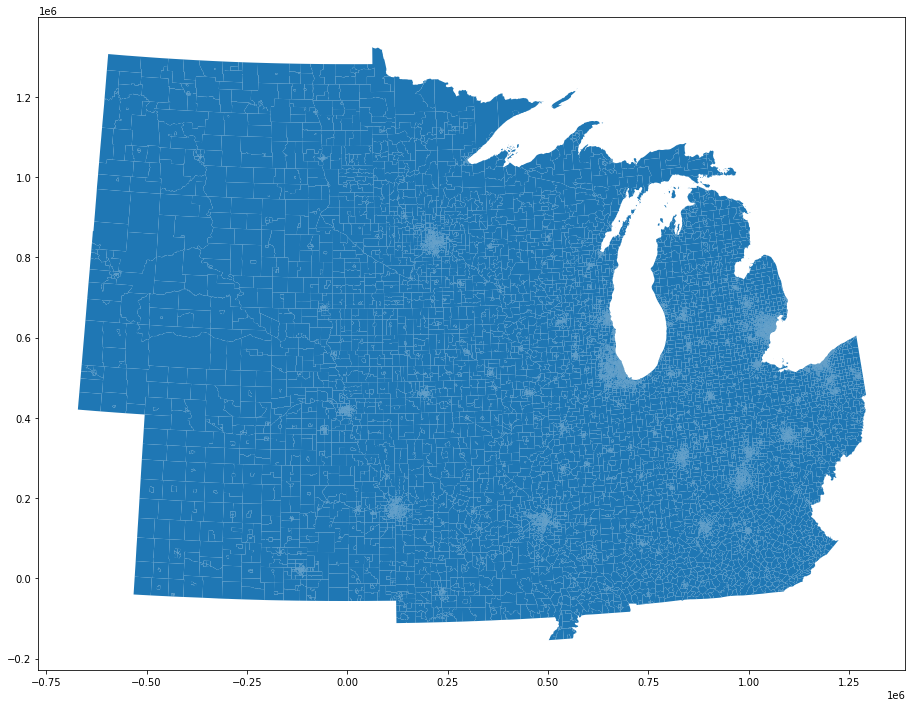

In [21]:
pop_data.plot(figsize=PARAMS["output"]["figsize"])

In [22]:
catchments = []
for dist_i, distance in enumerate(PARAMS["region"]["distances"]):
    catchments.append(gpd.read_file(os.path.join(PARAMS["region"]["dir"],PARAMS["region"]["catchment_file_pattern"].format(distance)), driver="GeoJSON"))
    catchments[dist_i] = catchments[dist_i][catchments[dist_i][PARAMS["resource"]["resource"]] > 0]
    catchments[dist_i] = catchments[dist_i].dropna(subset=[PARAMS["resource"]["resource"]])
    catchments[dist_i] = catchments[dist_i][(catchments[dist_i].geom_type == "Polygon") | (catchments[dist_i].geom_type == "MultiPolygon")]
    catchments[dist_i] = catchments[dist_i].to_crs(PARAMS["region"]["projection"])
catchments[0].head()

OBJECTID          ID                          NAME                 ADDRESS  \
0      1437  0009146952       MARION GENERAL HOSPITAL        441 N WABASH AVE   
1      1440  0010446750  PARKVIEW HUNTINGTON HOSPITAL          2001 STULTS RD   
2      1481  0016546992      PARKVIEW WABASH HOSPITAL           710 N EAST ST   
3      2251  0123645801         KINDRED HOSPITAL LIMA         730 W MARKET ST   
4      2287  0014645801      ST RITA'S MEDICAL CENTER  730 WEST MARKET STREET   

         CITY STATE    ZIP           ZIP4       TELEPHONE                TYPE  \
0      MARION    IN  46952  NOT AVAILABLE  (765) 660-6000  GENERAL ACUTE CARE   
1  HUNTINGTON    IN  46750  NOT AVAILABLE  (260) 355-3000  GENERAL ACUTE CARE   
2      WABASH    IN  46992  NOT AVAILABLE  (260) 563-3131     CRITICAL ACCESS   
3        LIMA    OH  45801  NOT AVAILABLE  (419) 224-1888      LONG TERM CARE   
4        LIMA    OH  45801  NOT AVAILABLE  (419) 226-4584  GENERAL ACUTE CARE   

   ...                                            WEBSITE     STATE_ID  \
0  ...                                 http://www.mgh.net  17-005011-1   
1  ...                            http://www.parkview.com  17-005081-1   
2  ...                          http://www.wchospital.com  17-005094-1   
3  ...                             http://www.khlima.com/         1425   
4  ...  http://www.ehealthconnection.com/regions/mercy...         1103   

        ALT_NAME ST_FIPS               OWNER  TTL_STAFF  BEDS         TRAUMA  \
0  NOT AVAILABLE      18          NON-PROFIT       -999    97  NOT AVAILABLE   
1  NOT AVAILABLE      18          NON-PROFIT       -999    36  NOT AVAILABLE   
2  NOT AVAILABLE      18  GOVERNMENT - LOCAL       -999    25  NOT AVAILABLE   
3  NOT AVAILABLE      39         PROPRIETARY       -999    26  NOT AVAILABLE   
4  NOT AVAILABLE      39          NON-PROFIT       -999   424       LEVEL II   

  HELIPAD                                           geometry  
0       Y  POLYGON ((866437.307 380901.927, 864605.865 38...  
1       Y  POLYGON ((873026.650 419467.105, 864478.852 42...  
2       Y  POLYGON ((850779.639 404409.709, 837591.117 41...  
3       Y  POLYGON ((992528.917 414382.389, 984151.472 42...  
4       Y  POLYGON ((992528.917 414382.389, 984151.472 42...  

[5 rows x 33 columns]

<AxesSubplot:>

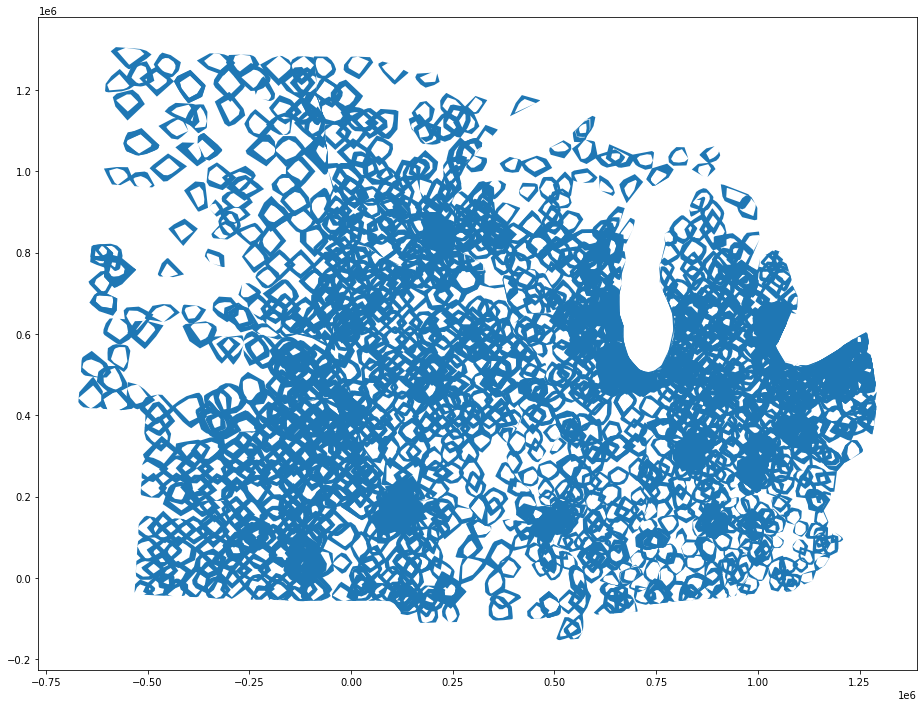

In [23]:
catchments[2].plot(figsize=PARAMS["output"]["figsize"])

In [24]:
result = e2sfca(catchments, PARAMS["access"]["val"], PARAMS["resource"]["key"], 
                   pop_data,
                   PARAMS["pop"]["pop_key"],
                   PARAMS["pop"]["pop_field"],
                   PARAMS["resource"]["resource"],
                   PARAMS["region"]["distances"],
                   PARAMS["access"]["weights"])

Calculating Intersections: 100%|████████████████████████████████████████████████████████| 3/3 [00:25<00:00,  8.62s/it]


In [25]:
result.head()

ST     STATE ST_ABBR STCNTY COUNTY         FIPS  \
0  17  ILLINOIS      IL  17031   Cook  17031381700   
1  17  ILLINOIS      IL  17031   Cook  17031980000   
2  17  ILLINOIS      IL  17031   Cook  17031980100   
3  17  ILLINOIS      IL  17097   Lake  17097863005   
4  17  ILLINOIS      IL  17097   Lake  17097863006   

                                      LOCATION  AREA_SQMI  E_TOTPOP  M_TOTPOP  \
0     Census Tract 3817, Cook County, Illinois   0.075986         0        11   
1     Census Tract 9800, Cook County, Illinois   7.679554         0        11   
2     Census Tract 9801, Cook County, Illinois   1.151272         0        11   
3  Census Tract 8630.05, Lake County, Illinois   0.393745       440       607   
4  Census Tract 8630.06, Lake County, Illinois   0.080025         0        11   

   ...  F_TOTAL  E_UNINSUR  M_UNINSUR  EP_UNINSUR  MP_UNINSUR  E_DAYPOP  \
0  ...     -999          0         11      -999.0      -999.0       551   
1  ...     -999          0         11      -999.0      -999.0     38202   
2  ...     -999          0         11      -999.0      -999.0      6449   
3  ...     -999          0         11      -999.0      -999.0       108   
4  ...     -999          0         11      -999.0      -999.0      2642   

   Shape_STAr  Shape_STLe                                           geometry  \
0    0.000021    0.020359  POLYGON ((689645.410 513172.412, 689877.534 51...   
1    0.002171    0.222431  POLYGON ((662183.100 533025.072, 662292.722 53...   
2    0.000323    0.076961  POLYGON ((678843.600 510378.604, 679647.276 51...   
3    0.000111    0.053599  POLYGON ((666628.417 566052.998, 666641.522 56...   
4    0.000023    0.018743  POLYGON ((666290.205 566023.937, 666268.776 56...   

   ratio-BEDS  
0    0.004524  
1    0.004148  
2    0.004004  
3    0.001478  
4    0.001478  

[5 rows x 128 columns]

In [26]:
result = result.to_crs(PARAMS["access"]["projection"])

In [27]:
result[PARAMS["access"]["val"]] = result[PARAMS["access"]["val"]] * 1000

To create our plot, let's add the outline of the state. To do that, we can load the county data and dissolve by state:

<AxesSubplot:>

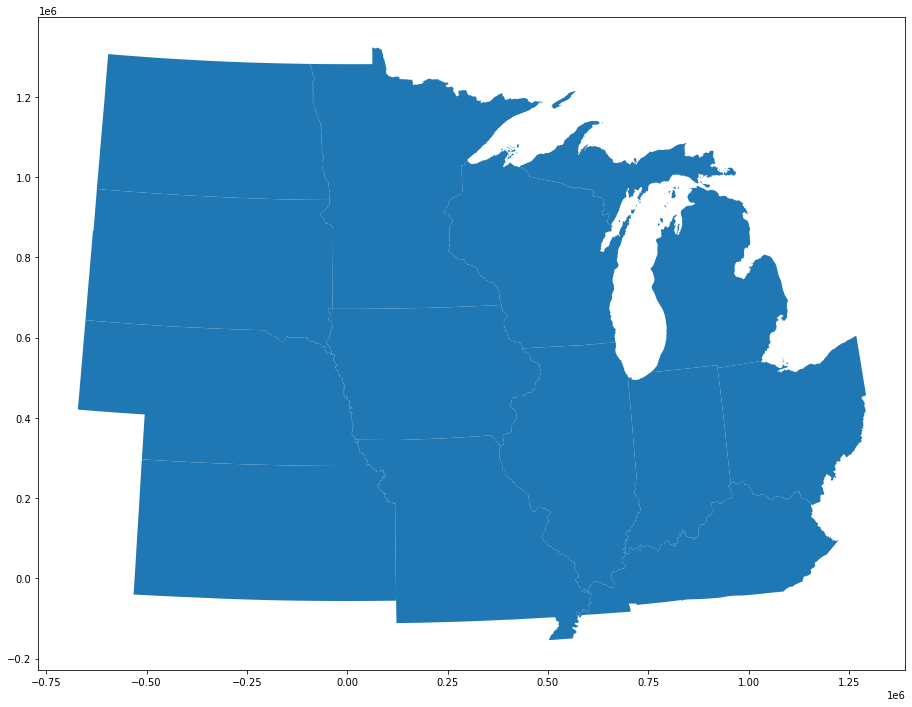

In [28]:
spatial_extent = gpd.read_file(PARAMS["graphml"]["geo_unit_shapefile"])
spatial_extent = spatial_extent.to_crs(PARAMS["access"]["projection"])
spatial_extent = spatial_extent.dissolve(by="STATEFP")
spatial_extent.plot(figsize=PARAMS["output"]["figsize"])

Lastly, let's plot our result:

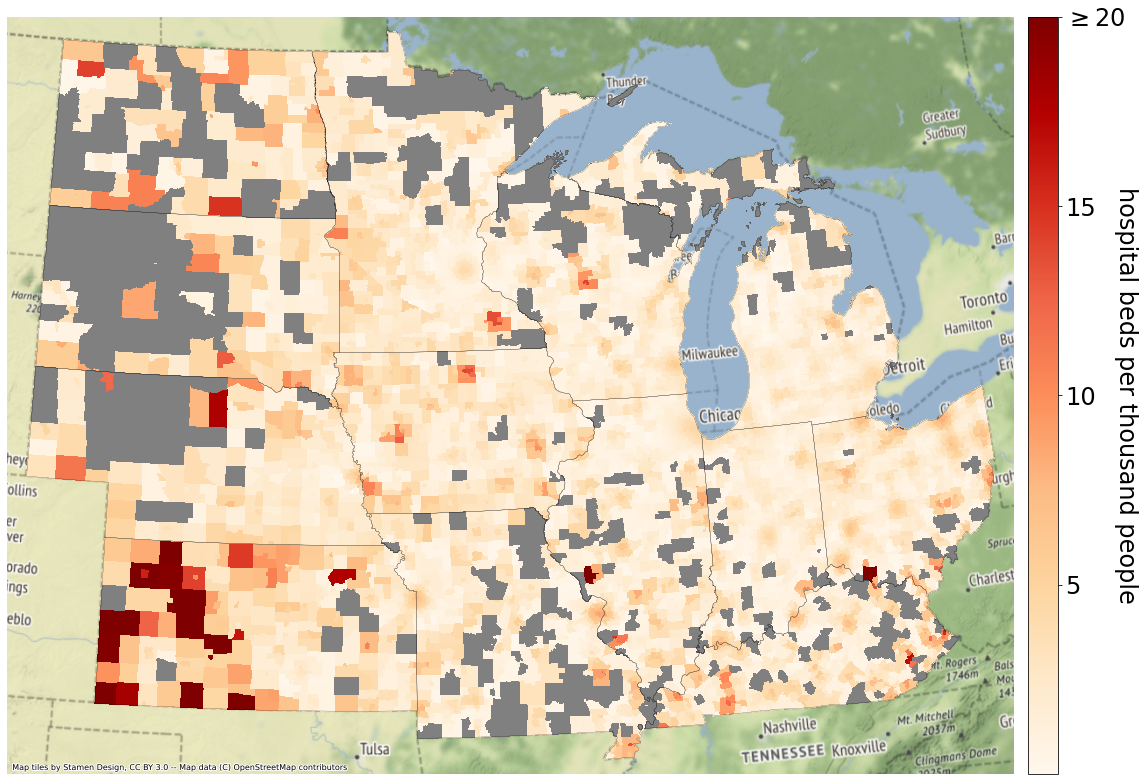

In [29]:
output_map(result, spatial_extent, PARAMS["access"]["val"],
           save=os.path.join(PARAMS["region"]["dir"], "E2SFCA-OrRd.jpg"), cmap='OrRd', 
           figsize=PARAMS["output"]["figsize"], colorbar_text="hospital beds per thousand people",
           vmax=20, integer_ticks=5)

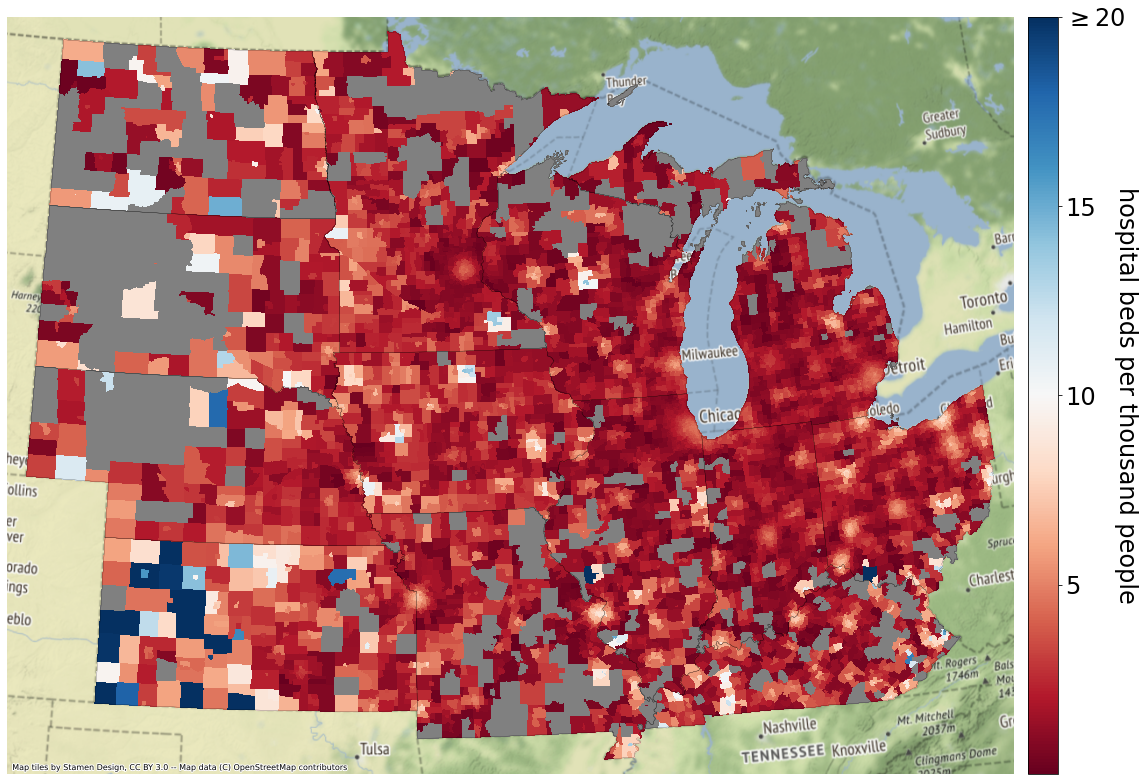

In [30]:
output_map(result, spatial_extent, PARAMS["access"]["val"],
           save=os.path.join(PARAMS["region"]["dir"], "E2SFCA-RdBu.jpg"), cmap='RdBu', 
           figsize=PARAMS["output"]["figsize"], colorbar_text="hospital beds per thousand people",
           vmax=20, integer_ticks=5)

<hr id="cont">

# Contiguous US

In [31]:
PARAMS = {
    "access": {
        "weights": [1.0, 0.68, 0.22],
        "projection" : "ESRI:102003",
    },
    "compute": {
        "max_memory" : 30,
        "threads" : 8
    },
    "graphml": {
        "geo_unit_key" : "GEOID",
        "geo_unit_shapefile" : "../data/geodata/counties/ConterminousCounties/ContinentalUS.shp",
        "dir" : "/data/cigi/common/michels9/graphmls/Continental/Continental-10kBuffer-20210628/graphml",
        "name_format" : "0500000US{}.graphml",
        "memory_csv" : "../data/memory_df/Continental-MemoryUsage.csv",
        "memory_column" : "Memory Usage (GB)",
        "memory_key" : "GEOID"
    },
    "output": {
        "figsize": [20,12],
    },
    "pop" : {
        "file": "../data/pop/continental/Continental_SVI_CT.shp",
        "pop_field": "E_TOTPOP",
        "pop_key": "FIPS"
    },
    "region" : {
        "batch_size": 8,
        "buffer": 64374,
        "catchment_file_pattern": "resource_catchments_{}distance.geojson",
        "catchment_how": "convexhull",
        "distances": [600, 1200, 1800],
        "dir": "../data/regions/Conterminous",
        "projection" : "ESRI:102003"
    },
    "resource" : {
        "key": "ID",
        "resource": "BEDS",
        "shapefile" : "../data/hospitals/continental/ContinentalHospitals.shp"
    }
}
PARAMS["access"]["val"] = "ratio-{}".format(PARAMS["resource"]["resource"])

In [32]:
pop_data = gpd.read_file(PARAMS["pop"]["file"])
pop_data = pop_data.to_crs(PARAMS["region"]["projection"])
pop_data[PARAMS["pop"]["pop_key"]] = pop_data[PARAMS["pop"]["pop_key"]].fillna(value=0)
pop_data.head()

FIPS  E_TOTPOP                                           geometry
0  01015981901         0  POLYGON ((917741.176 -378823.501, 917800.175 -...
1  01015981902         0  POLYGON ((917224.459 -377489.227, 917222.004 -...
2  01015981903         0  POLYGON ((938858.539 -378673.916, 939010.699 -...
3  01097003605       899  POLYGON ((745344.952 -729566.440, 745471.272 -...
4  01097990000         0  MULTIPOLYGON (((760323.731 -749311.532, 760524...

<AxesSubplot:>

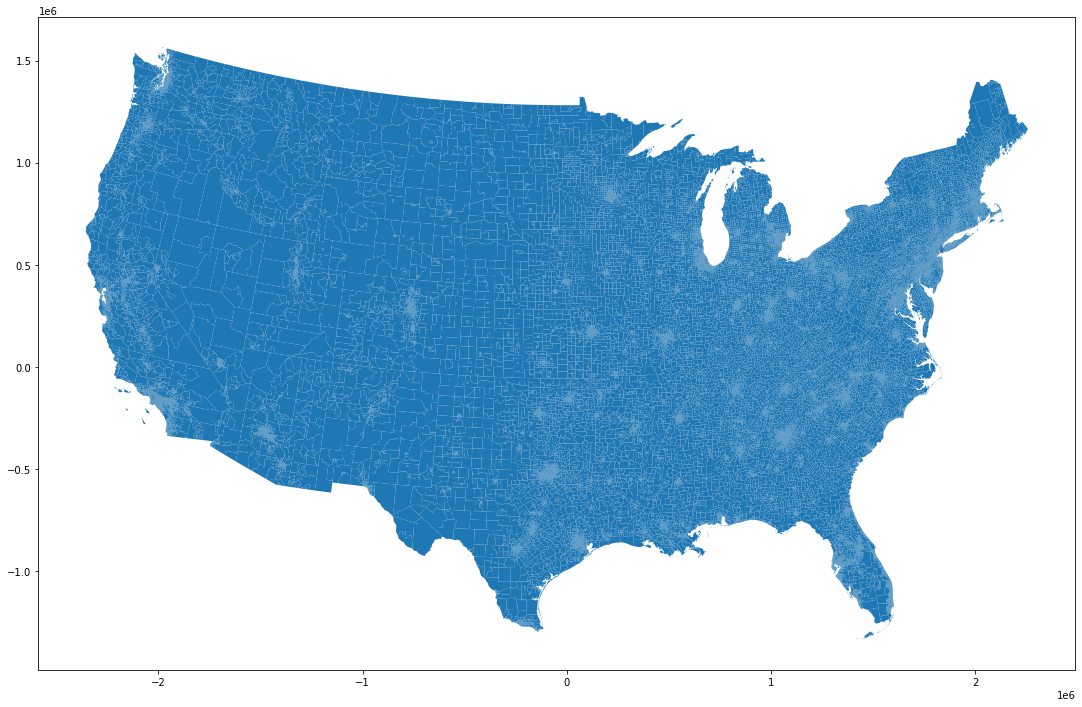

In [33]:
pop_data.plot(figsize=PARAMS["output"]["figsize"])

In [34]:
catchments = []
for dist_i, distance in enumerate(PARAMS["region"]["distances"]):
    catchments.append(gpd.read_file(os.path.join(PARAMS["region"]["dir"],PARAMS["region"]["catchment_file_pattern"].format(distance)), driver="GeoJSON"))
    catchments[dist_i] = catchments[dist_i][catchments[dist_i][PARAMS["resource"]["resource"]] > 0]
    catchments[dist_i] = catchments[dist_i].dropna(subset=[PARAMS["resource"]["resource"]])
    catchments[dist_i] = catchments[dist_i][(catchments[dist_i].geom_type == "Polygon") | (catchments[dist_i].geom_type == "MultiPolygon")]
    catchments[dist_i] = catchments[dist_i].to_crs(PARAMS["region"]["projection"])
catchments[0].head()

OBJECTID          ID                                        NAME  \
0      1404  0002846825                         DUPONT HOSPITAL LLC   
1      1405  0010246845  ORTHOPAEDIC HOSPITAL AT PARKVIEW NORTH LLC   
2      1413  0010646755                     PARKVIEW NOBLE HOSPITAL   
3      1425  0002946514                    ELKHART GENERAL HOSPITAL   
4      1426  0010046527              OAKLAWN PSYCHIATRIC CENTER INC   

                    ADDRESS          CITY STATE    ZIP           ZIP4  \
0          2520 E DUPONT RD    FORT WAYNE    IN  46825  NOT AVAILABLE   
1  11130 PARKVIEW CIRCLE DR    FORT WAYNE    IN  46845  NOT AVAILABLE   
2             401 SAWYER RD  KENDALLVILLE    IN  46755  NOT AVAILABLE   
3             600 EAST BLVD       ELKHART    IN  46514  NOT AVAILABLE   
4           330 LAKEVIEW DR        GOSHEN    IN  46527  NOT AVAILABLE   

        TELEPHONE                TYPE  ...  \
0  (260) 416-3023  GENERAL ACUTE CARE  ...   
1  (260) 672-4050  GENERAL ACUTE CARE  ...   
2  (260) 347-8700  GENERAL ACUTE CARE  ...   
3  (574) 294-2621  GENERAL ACUTE CARE  ...   
4  (574) 533-1234         PSYCHIATRIC  ...   

                              WEBSITE       STATE_ID       ALT_NAME ST_FIPS  \
0  http://www.thedupontdifference.com    17-002408-1  NOT AVAILABLE      18   
1                    www.parkview.com    17-005845-1  NOT AVAILABLE      18   
2             http://www.parkview.com    17-002434-1  NOT AVAILABLE      18   
3                  http://www.egh.org    12-005017-1  NOT AVAILABLE      18   
4              http://www.oaklawn.org  NOT AVAILABLE  NOT AVAILABLE      18   

         OWNER  TTL_STAFF  BEDS         TRAUMA HELIPAD  \
0  PROPRIETARY       -999   131  NOT AVAILABLE       Y   
1  PROPRIETARY       -999    37  NOT AVAILABLE       Y   
2   NON-PROFIT       -999    31  NOT AVAILABLE       Y   
3   NON-PROFIT       -999   270      LEVEL III       Y   
4   NON-PROFIT       -999    16  NOT AVAILABLE       N   

                                            geometry  
0  POLYGON ((902833.919 453651.922, 898574.476 45...  
1  POLYGON ((903004.207 454409.469, 898414.790 45...  
2  POLYGON ((891562.454 483275.821, 883696.533 48...  
3  POLYGON ((825721.933 502201.145, 817081.278 50...  
4  POLYGON ((840892.027 495736.995, 833628.786 49...  

[5 rows x 33 columns]

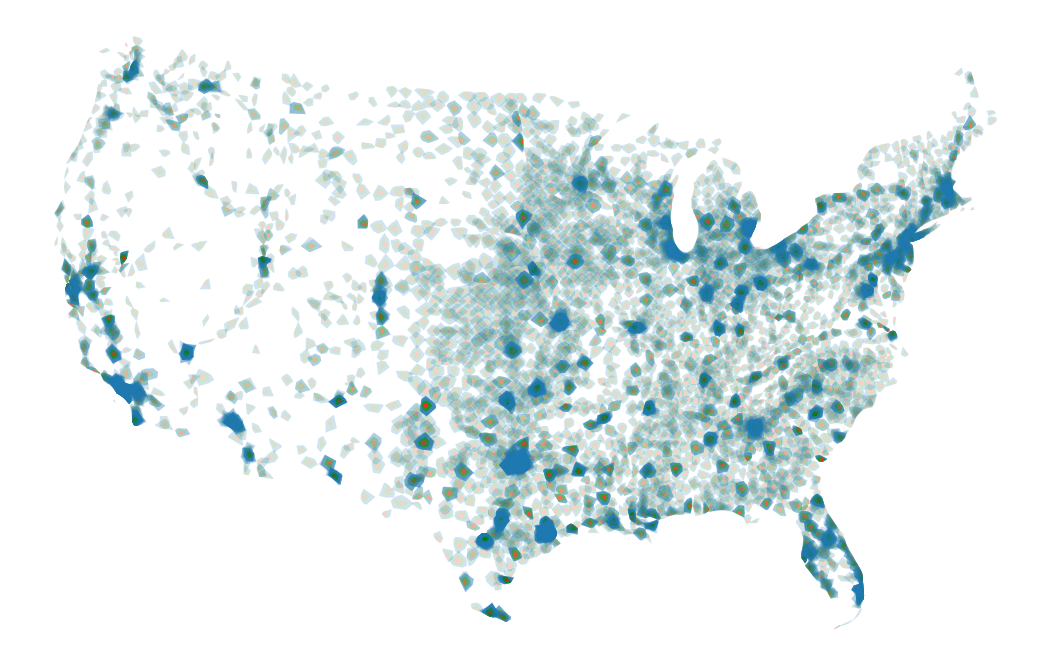

In [35]:
alpha = 0.2
ax = catchments[0].plot(figsize=PARAMS["output"]["figsize"], alpha=alpha, color='red')
catchments[1].plot(ax=ax, alpha=alpha, color='green')
catchments[2].plot(ax=ax, alpha=alpha)
ax.axis('off')
fig = plt.gcf()
fig.savefig(os.path.join(PARAMS["region"]["dir"], "ContinentalCatchments.jpg"), dpi=100, bbox_inches='tight')
plt.show()

In [36]:
result = e2sfca(catchments, PARAMS["access"]["val"], PARAMS["resource"]["key"], 
                   pop_data,
                   PARAMS["pop"]["pop_key"],
                   PARAMS["pop"]["pop_field"],
                   PARAMS["resource"]["resource"],
                   PARAMS["region"]["distances"],
                   PARAMS["access"]["weights"])

Calculating Intersections: 100%|████████████████████████████████████████████████████████| 3/3 [02:19<00:00, 46.52s/it]


In [37]:
result.head()

FIPS  E_TOTPOP                                           geometry  \
0  01015981901         0  POLYGON ((917741.176 -378823.501, 917800.175 -...   
1  01015981902         0  POLYGON ((917224.459 -377489.227, 917222.004 -...   
2  01015981903         0  POLYGON ((938858.539 -378673.916, 939010.699 -...   
3  01097003605       899  POLYGON ((745344.952 -729566.440, 745471.272 -...   
4  01097990000         0  MULTIPOLYGON (((760323.731 -749311.532, 760524...   

   ratio-BEDS  
0    0.004066  
1    0.004614  
2    0.004115  
3    0.005814  
4         NaN

In [38]:
result = result.to_crs(PARAMS["access"]["projection"])

In [39]:
result[PARAMS["access"]["val"]] = result[PARAMS["access"]["val"]] * 1000

To create our plot, let's add the outline of the state. To do that, we can load the county data and dissolve by state:

<AxesSubplot:>

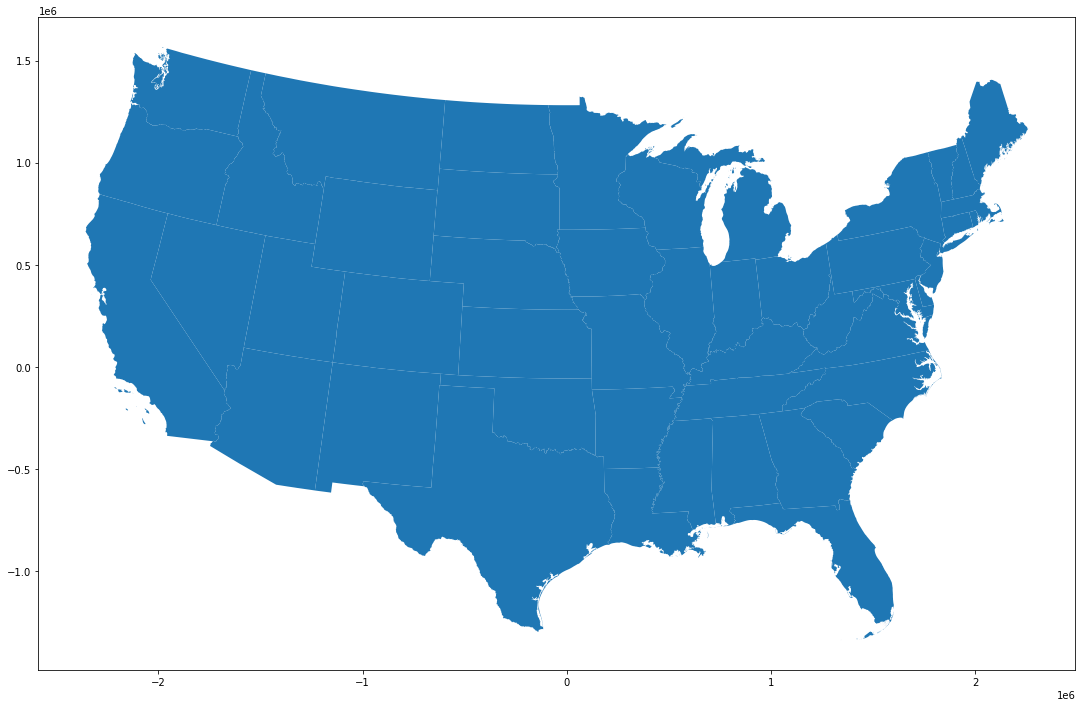

In [40]:
spatial_extent = gpd.read_file(PARAMS["graphml"]["geo_unit_shapefile"])
spatial_extent = spatial_extent.to_crs(PARAMS["access"]["projection"])
spatial_extent = spatial_extent.dissolve(by="STATEFP")
spatial_extent.plot(figsize=PARAMS["output"]["figsize"])

Lastly, let's plot our result:

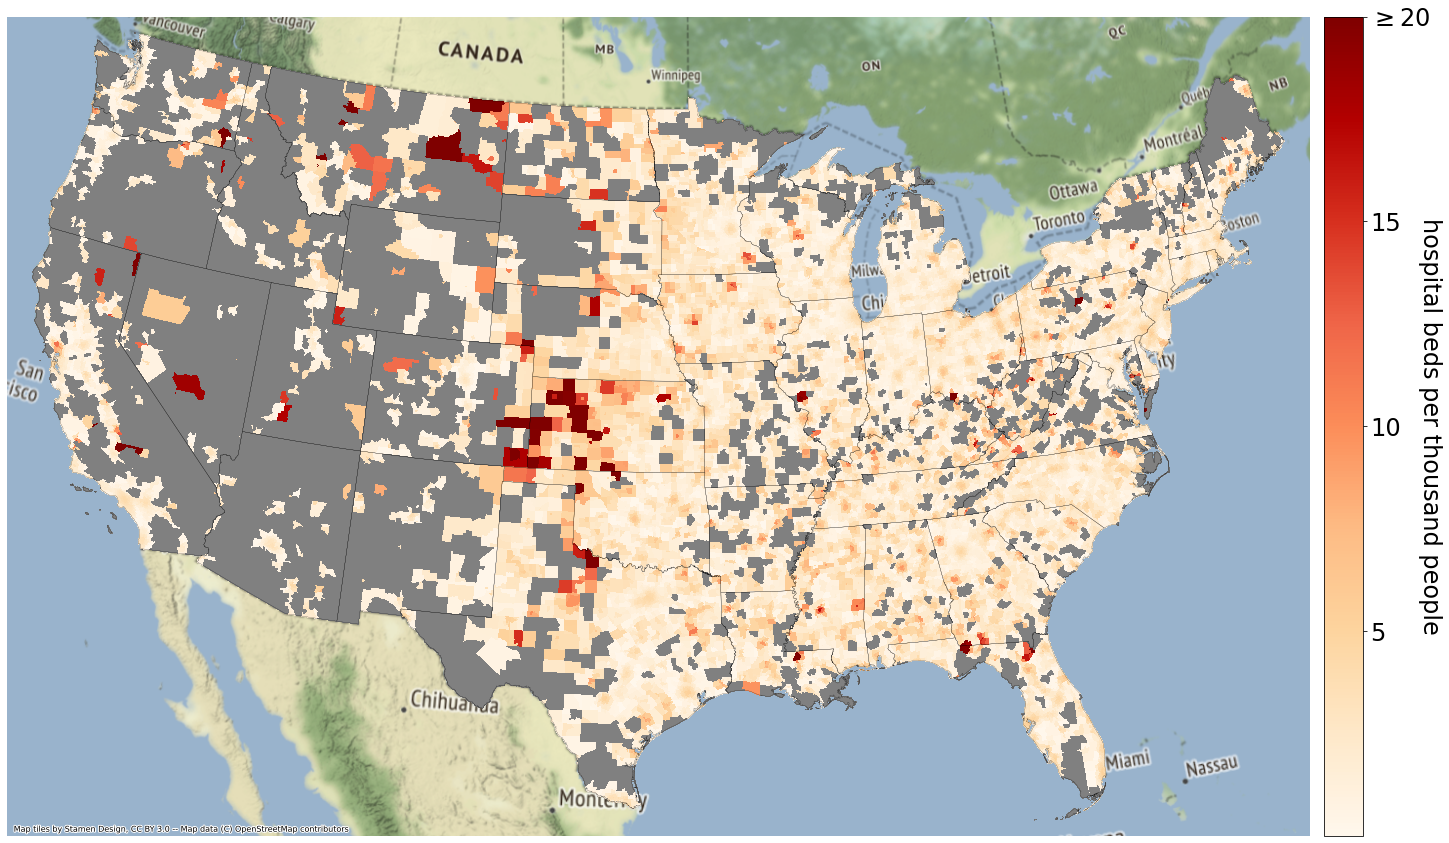

In [41]:
output_map(result, spatial_extent, PARAMS["access"]["val"],
           save=os.path.join(PARAMS["region"]["dir"], "E2SFCA-OrRd.jpg"), cmap='OrRd', 
           figsize=PARAMS["output"]["figsize"], colorbar_text="hospital beds per thousand people",
           vmax=20, integer_ticks=5)

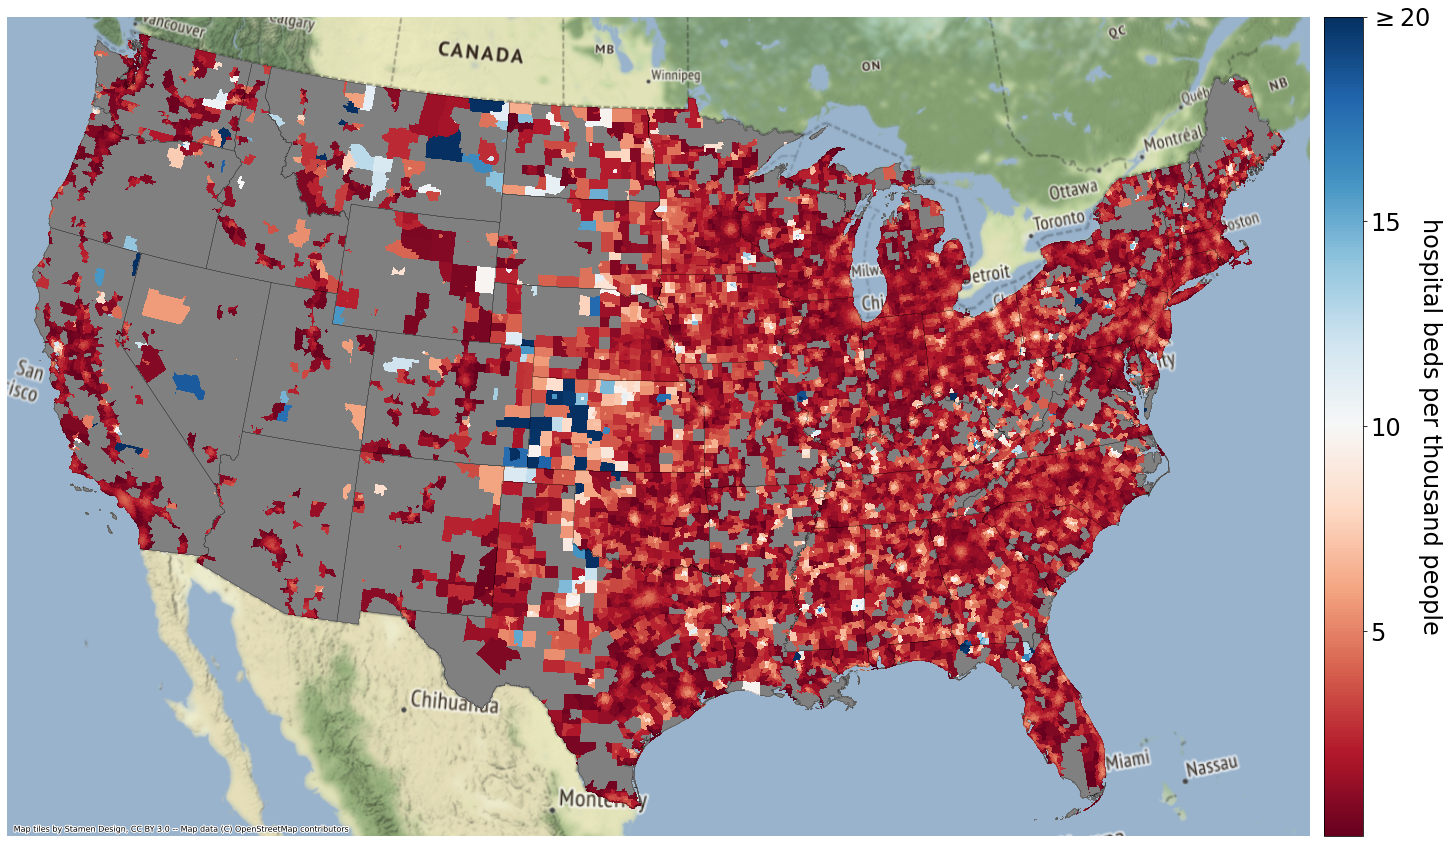

In [42]:
output_map(result, spatial_extent, PARAMS["access"]["val"],
           save=os.path.join(PARAMS["region"]["dir"], "E2SFCA-RdBu.jpg"), cmap='RdBu', 
           figsize=PARAMS["output"]["figsize"], colorbar_text="hospital beds per thousand people",
           vmax=20, integer_ticks=5)